# Paper Ai2Go

This is the jupter notebook for the planned paper. Here, we collect the results of the different SBATCH runs. This includes, the Teacher, Tutor but also Senior script. 

It is necessary to have the curriculum agent package installed

In [1]:
import os
os.chdir('/home/mlehna/AI2Go/l2rpn_binbinchen_iee')

In [2]:
import os
import gym
import grid2op
from lightsim2grid import LightSimBackend
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from pathlib import Path
import numpy as np
from lightsim2grid import LightSimBackend
import grid2op
import logging
import sys
import pandas as pd
from curriculumagent.common.utilities import array2action, get_from_dict_set_bus, extract_action_set_from_actions,find_best_line_to_reconnect,is_legal,split_action_and_return
from grid2op.Reward import RedispReward, L2RPNSandBoxScore
import random
import pickle
import json
import logging
from l2rpn_baselines.ExpertAgent.expertAgent import ExpertAgent
from typing import Dict, List, Optional, Tuple    
import plotly.express as px
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf

from grid2op.Agent import BaseAgent, DoNothingAgent
from curriculumagent.common.score_agent import load_or_run,render_report
from curriculumagent.submission.my_agent_advanced import MyAgent
from curriculumagent.submission.my_agent import MyAgent as OldAgent
from curriculumagent.tutor.tutors import original_tutor as original_tutor
from curriculumagent.tutor.tutors.general_tutor import GeneralTutor

from curriculumagent.tutor.tutors.n_minus_one_tutor import NminusOneTutor

# Set Seed
seed = 8888
random.seed(seed)


plt.rcParams['figure.figsize'] = [15, 5]
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

tf.__version__

'2.7.0'

In [3]:
#Collect test environment. If not available, use the track1_small environment
if Path("/share/data1/GYM/data_grid2op/l2rpn_neurips_2020_test").is_dir():
    TEST_PATH = "/share/data1/GYM/data_grid2op/l2rpn_neurips_2020_test"
else:
    TEST_PATH = "l2rpn_neurips_2020_track1_small"
    
backend = LightSimBackend()
env = grid2op.make(TEST_PATH, backend=backend)
env.set_id(random.choice(range(24)))
env.reset()
env.chronics_handler.get_name()
obs = env.get_obs()

2023-04-23 11:24:18 These dtypes could not be corrected: {'trafo': ['tap_min', 'tap_max']}


/share/data1/GYM/anaconda3/envs/expert/lib/python3.9/site-packages/pandapower/auxiliary.py:272: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item, dtype in list(dtypes.iteritems()):
/share/data1/GYM/anaconda3/envs/expert/lib/python3.9/site-packages/lightsim2grid/gridmodel/_aux_add_trafo.py:65: UserWarning: There were some Nan in the pp_net.trafo["tap_step_degree"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_degree\"], they have been replaced by 0")
/share/data1/GYM/anaconda3/envs/expert/lib/python3.9/site-packages/lightsim2grid/gridmodel/_aux_add_slack.py:113: UserWarning: We found either some slack coefficient to be < 0. or they were all 0.We set them all to 1.0 to avoid such issues
  warnings.warn("We found either some slack coefficient to be < 0. or they were all 0."


# Evaluation of Results 

Here we evaluate the results of the batch scrips. Below you can find the code for the Teacher-Tutor-Junior-Senior

## Evaluation of the Seed runs

After realizing, that the seed is key for the performance of the different agents, we run a total of 30 random seeds to gather a unbiased result 

In [4]:
from curriculumagent.tutor.tutor import general_tutor, n_minus_1_tutor

In [5]:
import pandas as pd
with open('paper/seed_res.pkl', 'rb') as handle:
    res_seed = pickle.load(handle)

with open('paper/collect_survival_time.pkl', 'rb') as handle:
    total_surv_time = pickle.load(handle)
    

names = ['Do Nothing Agent', 'Tutor Original', 'Tutor N-1','Tutor N-1 Topo', "Expert Agent",'Senior N-1 Topo checkpoint 1'] 

episode_names = ['apr19_1', 'apr19_2', 'aug02_1', 'aug02_2', 'dec16_1', 'dec16_2', 'feb20_1', 'feb20_2', 'jan32_1', 'jan32_2', 'jul28_1', 'jul28_2', 'jun14_1', 'jun14_2', 'mar39_1', 'mar39_2', 'may24_1', 'may24_2', 'nov46_1', 'nov46_2', 'oct05_1', 'oct05_2', 'sep21_1', 'sep21_2']

episode_names_sorted = [ 'jan32_1', 'jan32_2','feb20_1', 'feb20_2','mar39_1', 'mar39_2', 'apr19_1', 'apr19_2',  'may24_1', 'may24_2','jun14_1', 'jun14_2', 'jul28_1', 'jul28_2', 'aug02_1', 'aug02_2','sep21_1', 'sep21_2','oct05_1', 'oct05_2','nov46_1', 'nov46_2',  'dec16_1', 'dec16_2']


res_seed = pd.DataFrame(res_seed).transpose()
print(res_seed.columns)
res_seed.columns = names

res_seed = res_seed[['Do Nothing Agent', "Expert Agent", 'Tutor Original', 'Tutor N-1',
       'Tutor N-1 Topo', 'Senior N-1 Topo checkpoint 1']]

comb_surv = {}
for agent in total_surv_time[list(total_surv_time.keys())[0]].keys():
    surv_accross_seeds = []
    for s in list(total_surv_time.keys()):
        surv_accross_seeds.append(total_surv_time[s][agent])
    comb_surv[agent] = np.mean(np.array(surv_accross_seeds),axis=0)

surv_df = pd.DataFrame(comb_surv,index = episode_names)
surv_df = surv_df.loc[episode_names_sorted].reset_index()
surv_df.columns = ["episode_name"]+names

Index(['DoNothing_DoNothingAgent', 'T Original_Tutor', 'T N-1_NminusOneTutor',
       'T N-1 Topo_NminusOneTutor', 'ExpertAgent_ExpertAgent',
       'Senior 84301_0_ckpt_1410 fixed_MyAgent'],
      dtype='object')


In [6]:
out = res_seed.describe().round(2)
out

,Do Nothing Agent,Expert Agent,Tutor Original,Tutor N-1,Tutor N-1 Topo,Senior N-1 Topo checkpoint 1
count,30.0,30.00,30.00,30.00,30.00,30.00
mean,0.0,26.45,38.44,41.88,48.90,49.12
std,0.0,4.52,4.19,4.11,4.67,4.08
min,0.0,16.95,30.46,34.54,41.80,41.82
25%,0.0,24.03,35.75,38.97,44.67,45.53
50%,0.0,26.69,37.89,40.80,48.39,48.70
75%,0.0,29.88,40.81,45.75,53.40,51.15
max,0.0,35.96,47.42,51.61,58.23,58.69


In [7]:
out['Tutor N-1 Topo']["mean"]/out['Tutor Original']["mean"] -1

0.2721123829344434

<AxesSubplot: >

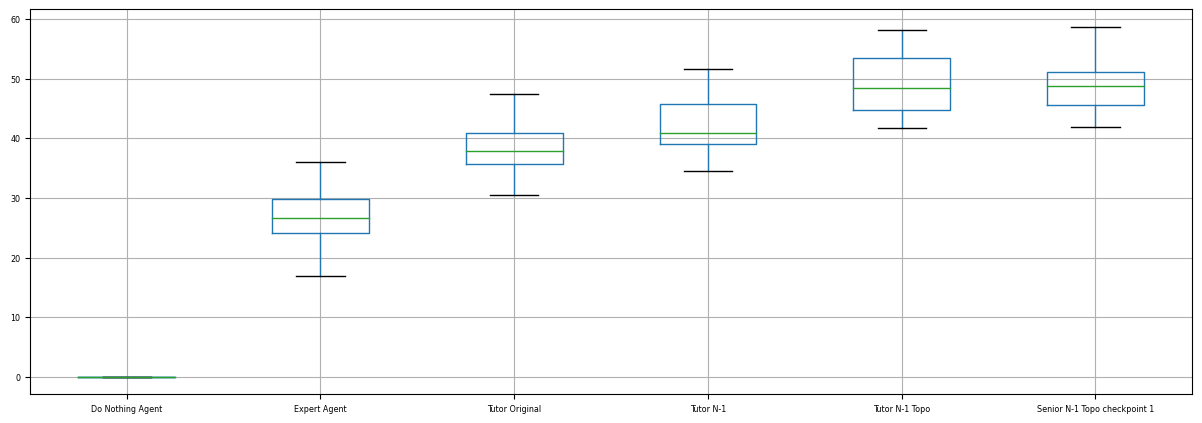

In [8]:
res_seed.boxplot(fontsize="xx-small")

#### Check for normal distribution of results: 

In [9]:
# D’Agostino and Pearson’s Test for normality with H_0: X ~N(mu,sigma)
from scipy import stats
for k in res_seed.columns: 
    k2, p = stats.normaltest(res_seed[k])
    print(f"The results of {k} have a p-value of {p} to be normal distributed")

The results of Do Nothing Agent have a p-value of nan to be normal distributed
The results of Expert Agent have a p-value of 0.7665184777850329 to be normal distributed
The results of Tutor Original have a p-value of 0.7389714563499463 to be normal distributed
The results of Tutor N-1 have a p-value of 0.46977576243892727 to be normal distributed
The results of Tutor N-1 Topo have a p-value of 0.11703058663441876 to be normal distributed
The results of Senior N-1 Topo checkpoint 1 have a p-value of 0.4434515443087137 to be normal distributed


Due to the fact that we can not reject the null hypothesis it could be possible that the data is normally distributed 


Now we test for the difference in sample with the Welch test 

In [10]:
test_c = [['Tutor Original',"Tutor N-1"],['Tutor Original',"Tutor N-1 Topo"] ,["Tutor N-1","Tutor N-1 Topo"] ,["Tutor N-1 Topo",'Senior N-1 Topo checkpoint 1']]

alpha = 0.05
res_dict= {}

for test_obj in test_c:
    k2,p = stats.ttest_ind(res_seed[test_obj[0]], res_seed[test_obj[1]], equal_var=False)
    if p < alpha: 
        out = f"We reject the H_0 hypothesis with a p-value of {p} and an alpha of {alpha}"
    else:
        out = f"We can not reject the H_0 hypothesis with a p-value of {p} and an alpha of {alpha}"
    
    print(f"Testing, whether the {test_obj[0]} and the {test_obj[1]} agent are from the same distribution. \n-> {out}")
    print()
    res_dict[test_obj[0]+" vs. "+test_obj[1]] = p
#pd.DataFrame(res_dict,index=["p-values"]).to_latex()

Testing, whether the Tutor Original and the Tutor N-1 agent are from the same distribution. 
-> We reject the H_0 hypothesis with a p-value of 0.002168783690807888 and an alpha of 0.05

Testing, whether the Tutor Original and the Tutor N-1 Topo agent are from the same distribution. 
-> We reject the H_0 hypothesis with a p-value of 8.753658139588256e-13 and an alpha of 0.05

Testing, whether the Tutor N-1 and the Tutor N-1 Topo agent are from the same distribution. 
-> We reject the H_0 hypothesis with a p-value of 6.995323013034676e-08 and an alpha of 0.05

Testing, whether the Tutor N-1 Topo and the Senior N-1 Topo checkpoint 1 agent are from the same distribution. 
-> We can not reject the H_0 hypothesis with a p-value of 0.845402453039686 and an alpha of 0.05



## Plots and specific result of seed

In [11]:
seed_pick = random.choice(res_seed.index)
print(seed_pick)
res_seed.loc[seed_pick]

678


Do Nothing Agent                 0.000000
Expert Agent                    29.149089
Tutor Original                  40.574429
Tutor N-1                       39.023404
Tutor N-1 Topo                  43.744006
Senior N-1 Topo checkpoint 1    48.318565
Name: 678, dtype: float64

In [12]:
backend = LightSimBackend()
env = grid2op.make(TEST_PATH,backend=backend)
test_flag=False

reward = RedispReward
other_rewards = {'grid_operation_cost': L2RPNSandBoxScore}
if Path("/share/data1/GYM/single_seed/"+str(seed_pick)).is_dir():
    out_path =Path("/share/data1/GYM/single_seed/"+str(seed_pick))
else:
    out_path = Path("single_seed/"+str(seed_pick))
    

    
# # Do nothing
do_nothing_agent = DoNothingAgent(env.action_space)
dn_report = load_or_run(agent = do_nothing_agent, env =env, output_path =out_path, name="DoNothing",nb_processes=1, number_episodes=24,seed =seed_pick, reinit=True )

#     # ------------------  Old Tutor  --------------------- #

tutor_original = original_tutor.Tutor(env.action_space, old_actionspace_path=Path("paper/action_spaces_paper"))
tutor_original_report = load_or_run(tutor_original, env = env,output_path = out_path, name="Tutor Original",nb_processes=1, number_episodes=24,seed =seed_pick )


# # Expert Agent: 
expert_agent = ExpertAgent(action_space = env.action_space,
                           observation_space = env.observation_space,
                           name= "Expert",
                           gridName="IEEE118_R2")
exp_report = load_or_run(agent = expert_agent, env =env, output_path =out_path, name="ExpertAgent",nb_processes=1, number_episodes=24,seed =seed_pick )

actions_n_minus_1 = [Path('paper/action_spaces_paper/n-1_actions_best_number.npy'),
                     Path('paper/action_spaces_paper/actions62.npy'),
                     Path('paper/action_spaces_paper/actions146.npy')]

# N-1 Agent: 
tutor_n1 = NminusOneTutor(action_space=env.action_space,
                       action_space_file = actions_n_minus_1,
                       do_nothing_threshold=0.9,
                       best_action_threshold=0.99,
                       rho_greedy_threshold=0.99,
                       lines_to_check=[45, 56, 0, 9, 13, 14, 18, 23, 27, 39],
                       return_status=True)


tutor_n1_repo = load_or_run(tutor_n1, env =env,output_path = out_path, name="Tutor N-1",nb_processes=1, number_episodes=24,seed =seed_pick )

# N-1 Agent: 
tutor_n1_topo = NminusOneTutor(action_space=env.action_space,
                       action_space_file = actions_n_minus_1,
                       do_nothing_threshold=0.9,
                       best_action_threshold=0.99,
                       rho_greedy_threshold=0.99,
                       lines_to_check=[45, 56, 0, 9, 13, 14, 18, 23, 27, 39],
                       return_status=True,
                       revert_to_original_topo = True)


tutor_n1_topo = load_or_run(tutor_n1_topo, env =env,output_path = out_path, name="Tutor N-1 Topo",nb_processes=1, number_episodes=24,seed =seed_pick )

with open('scaler_junior.pkl', "rb") as fp:   #Pickling
    scaler = pickle.load(fp)

my_agent_ckpt = MyAgent(
            action_space = env.action_space,
            model_path = Path("paper/checkpoint"),
            action_space_path = actions_n_minus_1,
            scaler = scaler,
            best_action_threshold = 0.95,
            topo = True
            )
ckpt_repo = load_or_run(my_agent_ckpt, env =env,output_path = out_path, name="Senior N-1 Topo",nb_processes=1, number_episodes=24,seed =seed_pick )

# Overwrite names if necessary: 
ckpt_repo.agent_name = "Senior N-1 Topo"
dn_report.agent_name = "DoNothing Agent"
exp_report.agent_name = "Expert Agent"
tutor_original_report.agent_name = "Tutor Original"
tutor_n1_repo.agent_name = "Tutor N-1"
tutor_n1_topo.agent_name = "Tutor N-1 Topo"

reports = [exp_report,
           tutor_original_report,
           tutor_n1_repo,
           tutor_n1_topo,
           ckpt_repo
           ] 


render_report(Path('report.md'),dn_report, reports)


2023-04-23 11:24:22 These dtypes could not be corrected: {'trafo': ['tap_min', 'tap_max']}
2023-04-23 11:24:22 Using cached results from /share/data1/GYM/single_seed/678/DoNothing_report_data.pkl
2023-04-23 11:24:22 Using cached results from /share/data1/GYM/single_seed/678/Tutor Original_report_data.pkl


/share/data1/GYM/anaconda3/envs/expert/lib/python3.9/site-packages/pandapower/auxiliary.py:272: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item, dtype in list(dtypes.iteritems()):
/share/data1/GYM/anaconda3/envs/expert/lib/python3.9/site-packages/lightsim2grid/gridmodel/_aux_add_trafo.py:65: UserWarning: There were some Nan in the pp_net.trafo["tap_step_degree"], they have been replaced by 0
  warnings.warn("There were some Nan in the pp_net.trafo[\"tap_step_degree\"], they have been replaced by 0")
/share/data1/GYM/anaconda3/envs/expert/lib/python3.9/site-packages/lightsim2grid/gridmodel/_aux_add_slack.py:113: UserWarning: We found either some slack coefficient to be < 0. or they were all 0.We set them all to 1.0 to avoid such issues
  warnings.warn("We found either some slack coefficient to be < 0. or they were all 0."


2023-04-23 11:24:22 the grid you indicated to the Expert System is:IEEE118_R2
2023-04-23 11:24:22 Using cached results from /share/data1/GYM/single_seed/678/ExpertAgent_report_data.pkl
2023-04-23 11:24:22 Using cached results from /share/data1/GYM/single_seed/678/Tutor N-1_report_data.pkl
2023-04-23 11:24:22 Using cached results from /share/data1/GYM/single_seed/678/Tutor N-1 Topo_report_data.pkl
2023-04-23 11:24:22 Action_space_path [PosixPath('paper/action_spaces_paper/n-1_actions_best_number.npy'), PosixPath('paper/action_spaces_paper/actions62.npy'), PosixPath('paper/action_spaces_paper/actions146.npy')] is a list containing multiple actions.
2023-04-23 11:24:22 SavedModel saved prior to TF 2.5 detected when loading Keras model. Please ensure that you are saving the model with model.save() or tf.keras.models.save_model(), *NOT* tf.saved_model.save(). To confirm, there should be a file named "keras_metadata.pb" in the SavedModel directory.


2023-04-03 11:24:22.746751: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-04-03 11:24:22.746797: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: compute-gpu-0-0.local
2023-04-03 11:24:22.746807: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: compute-gpu-0-0.local
2023-04-03 11:24:22.746935: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 450.80.2
2023-04-03 11:24:22.746978: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 450.80.2
2023-04-03 11:24:22.746986: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 450.80.2
2023-04-03 11:24:22.747252: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the foll

2023-04-23 11:24:23 Using cached results from /share/data1/GYM/single_seed/678/Senior N-1 Topo_report_data.pkl


/home/mlehna/AI2Go/l2rpn_binbinchen_iee/curriculumagent/common/score_agent.py:124: FutureWarning: Passing 'suffixes' which cause duplicate columns {'total_ts_x', 'all_scores_x'} in the result is deprecated and will raise a MergeError in a future version.
  score_merged = pd.merge(
/home/mlehna/AI2Go/l2rpn_binbinchen_iee/curriculumagent/common/score_agent.py:124: FutureWarning: Passing 'suffixes' which cause duplicate columns {'total_ts_x', 'all_scores_x'} in the result is deprecated and will raise a MergeError in a future version.
  score_merged = pd.merge(
/home/mlehna/AI2Go/l2rpn_binbinchen_iee/curriculumagent/common/score_agent.py:124: FutureWarning: Passing 'suffixes' which cause duplicate columns {'total_ts_x', 'ts_survived_x'} in the result is deprecated and will raise a MergeError in a future version.
  score_merged = pd.merge(
/home/mlehna/AI2Go/l2rpn_binbinchen_iee/curriculumagent/common/score_agent.py:124: FutureWarning: Passing 'suffixes' which cause duplicate columns {'tota

### Let's analyze the actions of the different agents: 
For this we run different plotting methods: 

In [13]:
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import numpy as np
import matplotlib as mpl
import plotly.graph_objects as go


def plot_actions_by_station_by_id(agents_results,agent_names, title, **fig_kwargs):
       
    comb_df = {}
    substations,act_ids = [],[]
    for name in agent_names:
        # Note, we adjusted the agents_results in order to work. You most likely have to skipp some of this code
        agent = agents_results.agents_data[agents_results.agents_names.index(name)]
        df  = agent.get_actions_by_substation_by_id_adj()
        comb_df[name] = df
        substations += list(df['susbtation'].unique())
        act_ids += list(df['action_id'].unique())
        
    substations = list(set(substations))
    act_ids = list(set(act_ids))
    
    replacement = {act:f"act_{i}" for i,act in enumerate(act_ids)}
    
    # Shuffle the substations to get the better colormap
    random.seed(1)
    random.shuffle(substations)
    
    cmap = mpl.cm.turbo
    cmap = mpl.cm.rainbow
    norm = mpl.colors.Normalize(vmin=1, vmax= len(substations)+1)
    cm = mpl.cm.ScalarMappable(cmap=cmap,norm=norm)
    color_dict = {sb: colors.to_hex(cm.to_rgba(len(substations)+1-i)) for i,sb in enumerate(substations)}
    color_dict
    
    all_figs = []
    for name in agent_names:
        df_n= comb_df[name].copy()
        df.sort_values("susbtation",ascending=False,inplace=True)
        # Replace action values: 
        df_n.replace({"action_id":replacement},inplace=True)    
        comb_df[name] = df_n.copy()
        
        df_n["color"] = df_n["susbtation"].map(color_dict)
        fig = px.sunburst(df_n, path=['susbtation', 'action_id'], values='nb_action',
                          # title=title + name,
                          color = 'susbtation',color_discrete_map =color_dict,template="plotly_white")
        #fig.update_layout(**fig_kwargs)
        fig.write_image(f"actions_by_station_id{name}.pdf")
        all_figs.append(fig)
    
    return all_figs,comb_df

def plot_bar_compa(score:pd.DataFrame, path:str) -> None:
    """
    Create Bar Plot of the perfomance
    Args:
        reports: Reports of the agents
        path: where to save the plot

    Returns: None

    """
    score_sub = score[["episode_name",'Do Nothing Agent', "Expert Agent", 'Tutor Original', 'Tutor N-1','Tutor N-1 Topo', 'Senior N-1 Topo checkpoint 1']]
    # Rename for plot: 
    score_sub.columns = ["episode_name",
                         f"DoNothing Agent: {score['Do Nothing Agent'].mean().round(1) }     ",
                         f"Expert Agent: {score['Expert Agent'].mean().round(1)}     ",
                         f"Tutor Original: {score['Tutor Original'].mean().round(1)}     ",
                         f"Tutor N-1: {score['Tutor N-1'].mean().round(1)}     ",
                         f"Tutor N-1 Topo: {score['Tutor N-1 Topo'].mean().round(1)}     ",
                         f"Senior N-1 Topo: {score['Senior N-1 Topo checkpoint 1'].mean().round(1)}     "]
    legends =list(score_sub.columns[1:])
    legends.reverse()
    
    fig = px.bar(score_sub, x="episode_name", y=legends, title="",barmode='group',template="plotly_white",width = 1000,height=500
                )

    fig.update_layout(xaxis={'rangeslider': {'visible': False}}, 
                      xaxis_title='Episode Name', yaxis_title='Average time steps survived')
    fig.update_layout(legend=dict(
        title="",
        orientation="h",
        entrywidth=140,
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        x=0.0
    ))

    fig.write_image(path)
    
def create_box(data):
    """
    Creating the Boxplot of the agents
    """
    res_seedc =data.copy()
    res_seedc.columns = [f"Do Nothing: {res_seedc['Do Nothing Agent'].median().round(2)}",
                         f"Expert: {res_seedc['Expert Agent'].median().round(2)}",
                         f"Original Tutor: {res_seedc['Tutor Original'].median().round(2)}",
                         f"Tutor N-1: {res_seedc[ 'Tutor N-1'].median().round(2)}",
                         f"Tutor N-1 Topo: {res_seedc['Tutor N-1 Topo'].median().round(2)}",
                         f"Senior N-1 Topo: {res_seedc['Senior N-1 Topo checkpoint 1'].median().round(2)}"]

    fig = go.Figure()
    # Use x instead of y argument for horizontal plot
    names =  list(res_seedc.columns).copy()
    names.reverse()
    for name in names:
        fig.add_trace(go.Box(x=res_seedc[name],name=name,
                            boxpoints='all', # can also be outliers, or suspectedoutliers, or False
                            jitter=0.3, # add some jitter for a better separation between points
                            pointpos=-1.8 # relative position of points wrt box
                            ))

    fig.update_layout(legend=dict(
                                    title="",
                                    orientation="h",
                                    entrywidth=160,
                                    yanchor="bottom",
                                    y=1.02,
                                    xanchor="left",
                                    x=0.0
                                ),
                      yaxis =  {'showticklabels': False,
                                'title': {'text': 'Agents'}},
                      xaxis = {'title': {'text': 'Total scenario score of agent per seed'}},


                     template="plotly_white",width =1000,height=500)

    fig.write_image("ResultsBox.pdf")
    
    
    

In [14]:
plotting = True

if plotting:     
    ####################################   All Seeds   ###############################################
    # All Seeds
    plot_bar_compa(score = surv_df, path = "Survival.pdf")
    create_box(res_seed)
    ##################################################################################################
    
    
    ####################################  Single Seed  ###############################################
    # Single Seed 
    agents_names= ["Tutor Original","Tutor N-1 Topo","Senior N-1 Topo"]
    ##################################################################################################
    
    # Plotting of substations: 
    # Actions by station Id
    from grid2bench.AgentsAnalytics import AgentsAnalytics
    import plotly.io as pio
    pio.renderers.default = 'jupyterlab'
    
    # Only after agent run !
    agents = AgentsAnalytics(data_path=out_path / "agent_logs",agents_names=agents_names)
    
    
    
    fig,comb_df = plot_actions_by_station_by_id(agents_results= agents,agent_names =agents_names,
                                                title = " "#"Action set by substation an action"
                                               )
    
    ##################################################################################################
    # Plotting of computation times (long and short plot)
     # TODO: Transfer to Episode data 
    comb_list = []
    for agent in agents.agents_data:
        df = agent.computation_times_several_episodes().copy()
        df.set_index("Timestamp",inplace=True)
        df.columns = [agent.agent_name]
        comb_list.append(df)


    com_df = pd.concat(comb_list,axis=1).dropna()
    com_df.reset_index(inplace=True)
    import plotly.express as px

    df = com_df.copy()


    fig = px.scatter(df, x="Timestamp", y=com_df.columns, marginal_y="rug",template="plotly_white",
                    labels={
                         "value": "Execution Time (in s)",
                         "Timestamp": "Grid2Op Scenarios",
                         "variable": ""
                     },width = 4000,height=400)
    fig.update_layout(legend=dict(
        orientation="h",
        entrywidth=100,
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        x=0.0
    ))
    #fig.update_xaxes(tickangle=90)
    
    fig.update_layout(xaxis = {'anchor': 'y', 'domain': [0.0, 0.75], 'title': {'text': 'Grid2Op Scenarios'}},
                      xaxis2 =  {'anchor': 'y2','domain': [0.8, 1.0],'matches': 'x2','showgrid': False,'showline': False,'showticklabels': True,
                                 'tickmode' :  'array',"tickvals" : ['Tutor Original',
                                                                     'Tutor N-1 Topo',
                                                                     'Senior N-1 Topo'],
                                 "ticktext" : ['T_O', 'T_N-1', 'Senior'], 'title': {'text': 'Frequency'},
                                "ticklabelposition": "outside left"},     
                      yaxis2 = {'anchor': 'x2', 'domain': [0.0, 1.0], 'matches': 'y','showgrid': False, 'showline': True, 'showticklabels': False})
    fig.write_image("Computation_time1.pdf")
    
    print([f'Tutor Original: {com_df["Tutor Original"].mean().round(4)}s',
           f'Tutor N-1 Topo: {com_df["Tutor N-1 Topo"].mean().round(4)}s',
           f'Senior N-1 Topo: {com_df["Senior N-1 Topo"].mean().round(4)}s'])
    
    fig = px.histogram(df, x="Timestamp",y=com_df.columns, marginal="rug",
                       )
    fig.write_image("Computation_time_large.pdf")
    com_df_copy = com_df.copy()
    com_df_copy.columns = ['Timestamp', 
                      f'Tutor Original with mean:    {com_df_copy["Tutor Original"].mean().round(4)}s',
                      f'Tutor N-1 Topo with mean:   {com_df_copy["Tutor N-1 Topo"].mean().round(4)}s',
                      f'Senior N-1 Topo with mean: {com_df_copy["Senior N-1 Topo"].mean().round(4)}s']
    fig = px.scatter(com_df_copy, x="Timestamp", y=com_df_copy.columns[1:], marginal_y="rug",template="plotly_white",
                labels={
                     "value": "Execution Time (in s)",
                     "Timestamp": "Grid2Op Scenarios",
                     "variable": ""
                 },width = 500,height=400)
    fig.update_layout(legend=dict(
        title="",
        orientation="h",
        entrywidth=240,
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        x=0.0
    ))
    #fig.update_xaxes(tickangle=90)

    fig.update_layout(xaxis = {'anchor': 'y', 'domain': [0.0, 0.65], 'title': {'text': 'Grid2Op Scenarios'},
                              "dtick":"M4","tickformat":"%b\n%Y"
                              },
                      xaxis2 =  {'anchor': 'y2','domain': [0.7, 1.0],'matches': 'x2','showgrid': False,'showline': False,'showticklabels': True,#"tickangle":90,
                                 'tickmode' :  'array',"tickvals" : list(com_df_copy.columns[1:]),
                                 # ['Tutor Original',
                                 #                                     'Tutor N-1 Topo',
                                 #                                     'Senior N-1 Topo'],
                                 "ticktext" : ['T_O', 'T_N-1', 'Senior'], 'title': {'text': '\n Frequency'}, 
                                "ticklabelposition": "outside right"},     
                      yaxis2 = {'anchor': 'x2', 'domain': [0.0, 1.0], 'matches': 'y','showgrid': False, 'showline': True, 'showticklabels': False})
    fig.write_image("Computation_time_short.pdf")
    
    ##################################################################################################
    # Plotting specific episode: 
    
        
    ep = "jul28_1"
    dist_list = []
    for agent in agents.agents_data:
        df = agent.distance_from_initial_topology(ep)
        df.set_index("Timestamp",inplace=True)
        df.columns = [agent.agent_name]
        dist_list.append(df)


    dist_df = pd.concat(dist_list,axis=1).dropna()
    dist_df.reset_index(inplace=True)
    
    fig = make_subplots(rows=3, cols=1,vertical_spacing = 0.1)

    for i,name in enumerate(dist_df.columns[1:]):
        fig.add_trace(
            go.Scatter(x=dist_df["Timestamp"], y=dist_df[name],mode='lines',name=name),#+markers
            row=i+1, col=1
        )
    fig.update_layout(yaxis = dict(tickmode = 'array',
                                   tickvals = [0,1, 2,3],
                                   ticktext = ["Original"+ "<br>"+"Topology",'1', '2', '3']),
                      yaxis2 = dict(tickmode = 'array',
                                   tickvals = [0,1, 2,3],
                                   ticktext = ["Original"+ "<br>"+"Topology",'1', '2', '3']),
                      yaxis3 = dict(tickmode = 'array',
                                   tickvals = [0,1, 2,3],
                                   ticktext = ["Original"+ "<br>"+"Topology",'1', '2', '3']),
                      height=600, width=600,
                      title_text="",
                      legend=dict(
                        orientation="h",
                        entrywidth=100,
                        yanchor="bottom",
                        y=1.02,
                        xanchor="left",
                        x=0.0),
                      template="plotly_white"                  
                     )
    fig.write_image(f"Distance in topology {ep}.pdf")
    
    
    
    ##################################################################################################
    # Plot Environment:
    backend = LightSimBackend()
    env = grid2op.make(TEST_PATH, backend=backend)
    env.set_id(1)
    env.reset()
    name = env.chronics_handler.get_name()
    obs = env.get_obs()
    #Plot Environment
    from grid2op.PlotGrid import PlotMatplot
    plot_helper = PlotMatplot(env.observation_space)
    fig = plot_helper.plot_obs(obs,storage_info=None,gen_info=None,load_info=None)
    #fig.show()
    fig.savefig(f"Grid {name}.pdf")
    
    
    ##################################################################################################
    # Other plots not used for paper: 
    # Plots based on Grid2Bench
    # Cumulative Reward
    fig  = AgentsAnalytics.plot_cumulative_reward(agents.agents_data)
    fig.write_image("cum_Rew.pdf")
    
    # Freq by station
    fig = AgentsAnalytics.plot_actions_freq_by_station_pie_chart(
    agents.agents_data,
    col=3,
    #title = "Frequency of actions by station"
    )
    
    fig.write_image("actions_freq.pdf")
    
    
    for name,resdf in comb_df.items():
        df_time = resdf[["susbtation","action_id","t_step"]].groupby(["susbtation","action_id"]).mean().reset_index()
        df_numb = resdf[["susbtation","action_id","nb_action"]].groupby(["susbtation","action_id"]).sum().reset_index()
        ordered = df_time.groupby(["susbtation"]).mean().reset_index().sort_values("t_step")["susbtation"]

        fig, ax = plt.subplots()
        ax.plot(df_time["t_step"],df_time["susbtation"],'o')
        #plt.title("Plot of substation action over time by the "+ name)
        ax.set_yticks(ordered)
        #plt.show()
        plt.savefig(f"sub_action_of_agent {name}.pdf") 

    fig = AgentsAnalytics.plot_lines_impact(
            agents.agents_data,
            title = " ",# "Overloaded lines",
            yaxis_type = "linear"
            )
    fig.write_image("Lines Overload.pdf")

    fig = AgentsAnalytics.plot_actions_freq_by_station(
            agents.agents_data,
            #title = "Frequency of actions by station",
            yaxis_type = "log"
            )
    fig.write_image("Frequency by station.pdf")
    
    fig = px.scatter(com_df, x="Timestamp", y=com_df.columns[1:], marginal_y="rug",template="plotly_white",
                labels={
                     "value": "Execution Time (in s)",
                     "Timestamp": "Grid2Op Scenarios",
                     "variable": ""
                 },width = 400,height=400)
    fig.update_layout(legend=dict(
        title="",
        orientation="h",
        entrywidth=240,
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        x=0.0
    ))
    #fig.update_xaxes(tickangle=90)

    fig.update_layout(xaxis = {'anchor': 'y', 'domain': [0.0, 0.65], 'title': {'text': 'Grid2Op Scenarios'},
                              "dtick":"M4","tickformat":"%b\n%Y"
                              },
                      xaxis2 =  {'anchor': 'y2','domain': [0.7, 1.0],'matches': 'x2','showgrid': False,'showline': False,'showticklabels': True,#"tickangle":90,
                                 'tickmode' :  'array',"tickvals" : list(com_df.columns[1:]),
                                 # ['Tutor Original',
                                 #                                     'Tutor N-1 Topo',
                                 #                                     'Senior N-1 Topo'],
                                 "ticktext" : ['T_O', 'T_N-1', 'Senior'], 'title': {'text': '\n Frequency'}, 
                                "ticklabelposition": "outside right"},     
                      yaxis2 = {'anchor': 'x2', 'domain': [0.0, 1.0], 'matches': 'y','showgrid': False, 'showline': True, 'showticklabels': False})
    fig.write_image("Computation_time_short.pdf")

100%|██████████| 24/24 [01:37<00:00,  4.05s/it]


Calculating actions id


24it [00:04,  5.15it/s]


Calculating actions id


24it [00:10,  2.23it/s]


Calculating actions id


24it [00:08,  2.83it/s]


['Tutor Original: 0.0079s', 'Tutor N-1 Topo: 0.0739s', 'Senior N-1 Topo: 0.0152s']
2023-04-23 11:31:36 These dtypes could not be corrected: {'trafo': ['tap_min', 'tap_max']}


/share/data1/GYM/anaconda3/envs/expert/lib/python3.9/site-packages/pandapower/auxiliary.py:272: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/share/data1/GYM/anaconda3/envs/expert/lib/python3.9/site-packages/lightsim2grid/gridmodel/_aux_add_trafo.py:65: UserWarning:

There were some Nan in the pp_net.trafo["tap_step_degree"], they have been replaced by 0

/share/data1/GYM/anaconda3/envs/expert/lib/python3.9/site-packages/lightsim2grid/gridmodel/_aux_add_slack.py:113: UserWarning:

We found either some slack coefficient to be < 0. or they were all 0.We set them all to 1.0 to avoid such issues

/tmp/ipykernel_14904/2326692237.py:200: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/tmp/ipykernel_14904/2326692237.py:200: FutureWarning:

The defa

In [16]:
do_you_have_a_lot_of_time = False

if do_you_have_a_lot_of_time:
    # Make GIF from one Episode of the Senior agent:
    from grid2op.Episode import EpisodeReplay
    from grid2op.Agent import GreedyAgent, RandomAgent
    from grid2op.Runner import Runner
    from tqdm import tqdm
    if plotting: 
        path_agent= out_path / "/agent_logs/Senior N-1 Topo"
        # and now reload it and display the "movie" of this scenario
        # We take an "hard" scenario, because the generation takes a lot of time. 
        plot_epi = EpisodeReplay(path_agent)
        plot_epi.replay_episode("jan32_1", gif_name="jan32_1")

# Experiment Workflow: 
<span style="color:blue">
The next section shows the Experiment workflow. This requires quite a lot of calculation. We provide all scripts for the curriculum agent, also for slurm clusters. 
Add the paths after running the code 
</span>



#### Files: 

Teacher:<br />
`run_teacher_n1.py` -> Run the N-1 Search of the Teacher to get the experience<br />

Tutor:<br />
`run_tutor_N-1_topo.py` -> Run the N-1 Tutor to get the observation and action sets

Junior: <br />
`scaler_junior.pkl` -> Sklearn Scaler of the Junior Model <br />
`config.yml` -> config file for the NNI Hyperparameter optimisation<br />
`hps_junior_nni.py` -> Hyperparameter script for the Junior<br />
`search_space.json` -> Search space of the hyperparameter<br />
`best_params.json` -> Best parameters of the NNI search<br />

Senior: <br />
The training of the Senior is done in this notebook

Evaluation: <br />
`get_seed.py` -> Evaluation script of the different model, to evaluate the agents. The results is the `seed_res.pkl`, which we import in this notebook 

## Teacher 

This section shows the code, where we collected the Teacher experience of the N-1 Action space. The N-1 Teacher was run before this on our cluster (code included).

Adjust the paths in the methods accordingly 

In [ ]:
from curriculumagent.teacher.collect_teacher_experience import make_unitary_actionspace
gather_actions = False
if gather_actions: 
    make_unitary_actionspace(action_space_file_path =Path("n1_actions.npy") ,
                             experience_csv_files = ['teacher_experience.csv'],
                             env_name_path = "l2rpn_neurips_2020_track1_small",
                             best_n = 300)
    plt.ylim((0,200))
    plt.show()

## Tutor

Here, we collect the tutor data from running the N-1 Tutor (again on the cluster). The output is then the Junior data.

Adjust the paths to your liking

In [ ]:
from curriculumagent.tutor.collect_tutor_experience import prepare_dataset, generate_tutor_experience

generate_data = False
if generate_data:
    prepare_dataset(traindata_path=Path("junior_n1_topo"),
                    target_path=Path("n1_topo"),
                    filtered_obs=True,
                    dataset_name="n1data_topo",
                    seed=8888)  
        

## Junior

Let's aggregate the result of the junior and train with it. Thus we load The Dataset of n1_data_topo and use it as our scaler.

After the creation, we look at the histogram and the maximum value: One can see that the N-1 Actions are used with a high proportion. 

In [ ]:
# Load The Dataset of n1_data_topo and use it as our scaler: 
from curriculumagent.junior.junior_student import Junior,load_dataset,train 
from sklearn.preprocessing import StandardScaler
import pickle 

run_simple_junior = True
if run_simple_junior:
    target = Path("junior_n1_topo")
    s_train, a_train, s_validate, a_validate, s_test, a_test = load_dataset(target,dataset_name="n1data_topo")


    scaler =StandardScaler()
    s_tr_t = scaler.fit_transform(s_train)
    s_val_t = scaler.transform(s_validate)
    s_test_t = scaler.transform(s_test)

    
    print(np.max(a_test))
    plt.hist(a_train,bins=150)
    
    with open('scaler_junior.pkl', 'wb') as fp:   #Pickling
        pickle.dump(scaler,fp)

Now, let's train the Junior (as a test) prior to the hyperparameter configuration. 

In [ ]:
if run_simple_junior:
    junior = Junior(trainset_size = len(a_train), epochs  = 1000,num_actions =np.max(a_test)+1, learning_rate  = 5e-7,activation = "relu")

    history = junior.train(log_dir =  Path("tfboard"),
                  ckpt_dir = Path("ckpt-junior-n1") ,
                  x_train =  s_tr_t, y_train= a_train,
                  x_validate = s_val_t, y_validate = a_validate,
                epochs  = 1000)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history['val_accuracy'])
    junior.test( s_test_t, a_test)
    junior.model.save("ckpt-junior-n1")

#### Advanced Junior Model 

After the hyper-parameteroptimization, we now train the Junior with best hyperparameters.

For this we have to use the advanced model to initialize it with the hyperparameters

In [ ]:
import tensorflow as tf
with open('best_params.json') as json_file:
    best_params = json.load(json_file)

best_params["epochs"] = 1000
best_params["initializer"] = tf.keras.initializers.Orthogonal()
for name in ["layer1","layer2","layer3","layer4"]:
        best_params[name] = np.round(best_params[name])
    
best_params

In [ ]:
from curriculumagent.junior.hyper_parameter_search.advanced_junior_student import AdvancedJunior

In [ ]:
run_adv_junior = False

if run_adv_junior:
    junior = AdvancedJunior(config=best_params,
                            trainset_size=len(a_train),
                            num_actions= np.max(a_test)+1,
                            seed = 15)

    history = junior.train(log_dir=Path('n1/train'),
                           ckpt_dir=Path('n1/train'),
                           patience=50,
                           x_train=s_tr_t, y_train=a_train,
                           x_validate=s_val_t, y_validate=a_validate)
    print(junior.model.summary())
    plt.plot(history.history["accuracy"])
    plt.plot(history.history['val_accuracy'])

    junior.model.save(Path('n1_topo'))
    junior.test(s_test_t, a_test)
    
    model = tf.keras.models.load_model(Path('best-junior-n1'))
    
    model.predict(s_test_t)

# Senior
Now we can run the senior model. Due to some specifications of RLlib, this is quite dependent on your machine

In [ ]:
import os
os.getcwd()

import random
import pickle
import logging
import ray
import ray.tune as tune
import ray.rllib as rllib
import tensorflow as tf
from ray.rllib.models import ModelCatalog
from ray.tune.schedulers import PopulationBasedTraining
from curriculumagent.senior.rllib_execution.senior_env_rllib import SeniorEnvRllib
from curriculumagent.senior.rllib_execution.senior_model_rllib import Grid2OpCustomModel, AdvancedCustomModel
from curriculumagent.scripts.run_rllib_with_advanced_model import train_senior,try_configs,get_n1_experiment_configs
from  grid2op.Reward import FlatReward
from curriculumagent.senior.rllib_execution.TopoRew import TopoRew

In [ ]:
print(tf.__version__)
os.cpu_count()
ray.shutdown()

ray_training = True # True, False, Extraction
NUM_TRIALS = 4
NUM_CPUS = 32
NUM_GPUS = 0

if ray =="Extraction": 
    ray.init(num_cpus=os.cpu_count(), object_store_memory=32000000000, num_gpus=1,log_to_driver=False,dashboard_port =8042,ignore_reinit_error=True)
elif ray_training:
    ray.init(num_cpus=NUM_CPUS, object_store_memory=32000000000, num_gpus=NUM_GPUS,log_to_driver=False,dashboard_port =8042,ignore_reinit_error=True)
else:
    pass

print("Ray works: {ray.is_initialized()}")

Now lets Init the Environment and the scalers: 

In [ ]:
with open('/home/mlehna/AI2Go/l2rpn_binbinchen_iee/scaler_junior.pkl', "rb") as fp:   #Pickling
    scaler = pickle.load(fp)
if ray.is_initialized():
    ray_scal = ray.put(scaler)
else:
    ray_scal = scaler

from pathlib import Path
actions_n_minus_1 = [Path('action_spaces_paper/n-1_actions_best_number.npy'),
                     Path('action_spaces_paper/actions62.npy'),
                     Path('action_spaces_paper/actions146.npy')]
junior_model = Path('/share/data1/GYM/junior/paper/n1_topo/junior')
env_config = {"action_space_path":actions_n_minus_1,
              "env_path": "l2rpn_neurips_2020_track1_small",
              "action_threshold":0.95,
              'filtered_obs':True,
              'scaler': ray_scal,
              'topo':True,
              'alternative_rew': TopoRew
             } #
target = Path('best-junior-n1')

import json
import numpy as np
with open('best_params.json') as json_file:
    best_params = json.load(json_file)
    
best_params["epochs"] = 1000
best_params["initializer"] = tf.keras.initializers.Orthogonal()
for name in ["layer1","layer2","layer3","layer4"]:
        best_params[name] = np.round(best_params[name])
    
print(best_params)


rllib_env = SeniorEnvRllib(env_config)
a = rllib_env.reset()
if False:
    model = AdvancedCustomModel(obs_space = rllib_env.observation_space,
                                action_space = rllib_env.action_space,
                               num_outputs = rllib_env.action_space.n,
                               model_config={},
                               path_to_junior = junior_model,
                               custom_config = best_params,
                               name="Junior")
    obs = {"obs":a.reshape(1,-1)}
    b = model.forward(input_dict = obs, state=1, seq_lens=None)
    print("Model seems to be working")
    
model_config = {"path_to_junior":target,
                "custom_config":best_params}

ModelCatalog.register_custom_model('SeniorN1',  AdvancedCustomModel)

if ray_training:
    rllib_env.reset()
    done = False
    while done==False: 
        act = random.choice(np.arange(rllib_env.action_space.n))
        a,b,done,d = rllib_env.step(act)
        print(act,done,b,rllib_env.step_in_env,max(a),min(a),rllib_env.single_env.nb_time_step)

Run training. Note this can take a while, so be cautious!

In [ ]:
if isinstance(ray_training,bool) and ray_training==True:
    pbt = PopulationBasedTraining(
            time_attr="training_iteration",
            metric="episode_reward_mean",
            mode="max",
            perturbation_interval=50,
            resample_probability=0.5,
            # Specifies the mutations of these hyperparams
            hyperparam_mutations={
                "lr": [1e-3, 5e-4, 1e-4, 5e-5, 1e-5],
                #"sample_batch_size": lambda: random.randint(1, 128),
                #"train_batch_size": lambda: random.randint(2048, 8096),
                #"sgd_minibatch_size": lambda: random.randint(20, 128),
                "num_sgd_iter": lambda: random.randint(3, 10),
                "vf_loss_coeff": lambda: random.uniform(0.5,1),
                "clip_param": lambda: random.uniform(0.01, 0.5),
                "gamma": lambda: random.uniform(0.975, 1),
                "entropy_coeff": lambda: 10**-random.uniform(2,5)
            })



    tune.run(
        "PPO",
        name="Senior TopoRew",
        checkpoint_freq=10,
        scheduler= pbt,
        keep_checkpoints_num = 100, 
        verbose = 0,
        reuse_actors = True,
        max_failures=3, 
        num_samples=NUM_TRIALS,
        stop={"training_iteration": 5000},
        config={
            "env":  SeniorEnvRllib,
            "env_config":env_config,
            "num_workers":int((NUM_CPUS - NUM_TRIALS-2) / NUM_TRIALS),
            "num_envs_per_worker": 1,
            "lr": 5e-5,
            "num_gpus":int(NUM_GPUS / NUM_TRIALS),
            "num_cpus_per_worker": 1,
            "remote_worker_envs": False,
            "model":{"custom_model":  "SeniorN1","custom_model_config": model_config},
            "framework": "tf"
        },
    )
    ray.shutdown()

### Load Senior Model and Create Agent
After training you should load and save the model as tf-model


Note: You have to add the path of the RLlib experiment by yourself. 

In [ ]:
from curriculumagent.senior.rllib_execution.convert_rllib_ckpt import load_config, load_and_save_model

In [ ]:
path_of_experiments = [ ### Enter Path of RLlib here ###]

list_of_ckpt = []

load_dict = {}
for pt in path_of_experiments:
    ckpts = [os.path.join(path, n) for path, subdirs, files in os.walk(pt)
                         for n in files  if "checkpoint-" in n and "tune_metadata" not in n]
    list_of_ckpt += ckpts
    for name in ckpts:
        load_dict[name[65:70]+"_"+name[75]+"_"+name[-4:] ] = [Path(pt),Path(name)]

        
if ray_training=="Extraction":
               
    for k,v in load_dict.items():
        agent_path = Path("senior")/k[:-5]

        config, ckpt_path = load_config(v[0], latest=False)
        config["env_config"] = env_config
        config["model"]["custom_model_config"]["custom_config"] = model_config['custom_config']

        best_checkpoint =v[1]
        
        ckpt_nr = k[-4:] if "-" not in k[-4:] else k[-3:]
        if agent_path.is_dir():
            if "ckpt_"+ckpt_nr in os.listdir(agent_path):
                print("ckpt_"+ckpt_nr+ " already exists")
                continue
        load_and_save_model(ckpt_path=best_checkpoint, config=config, save_path=agent_path,ckpt_nr=int(ckpt_nr))
        print(f"Done with {k}")
        
    
ray.shutdown()

The Agent were then run in the "get_seed.py" file together with the Tutors to get the final evaluation